GIF saved as 'adaptive_particle_filter_uniform.gif'


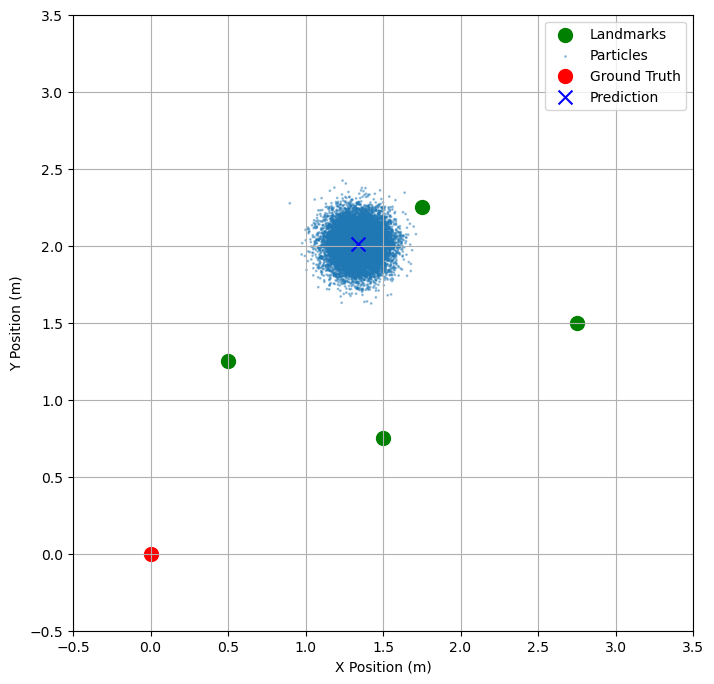

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import scipy.stats

# Constants
DELTA_T = 0.01  # Time step (seconds)
AREA_LIMIT = 3.0  # 3x3 square
NUM_PARTICLES = 15000  # Initial number of particles
MOTION_NOISE = [0.1, 0.1, np.deg2rad(1)]  # Noise in [x, y, theta]
LANDMARKS = [[1.5, 0.75], [2.75, 1.5], [1.75, 2.25], [0.5, 1.25]]  # Landmarks in the area

# Load tf_data (ground truth as input for now)
def load_tf_data(filename):
    """Load tf_data (ground truth) from a CSV file."""
    df = pd.read_csv(filename)
    df['yaw'] = np.arctan2(2 * (df['rotation_w'] * df['rotation_z'] + df['rotation_x'] * df['rotation_y']),
                           1 - 2 * (df['rotation_y']**2 + df['rotation_z']**2))
    return df['translation_x'], df['translation_y'], df['yaw']

# Particle Filter Class
class ParticleFilter:
    def __init__(self, num_particles, area_limit):
        self.num_particles = num_particles
        self.area_limit = area_limit
        self.particles = self.create_uniform_particles((0, area_limit), (0, area_limit), (-np.pi, np.pi), num_particles)
        self.weights = np.ones(num_particles) / num_particles

    def create_uniform_particles(self, x_range, y_range, hdg_range, N):
        """Initialize particles uniformly."""
        particles = np.empty((N, 3))
        particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
        particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 2] = np.random.uniform(hdg_range[0], hdg_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        return particles

    def predict(self, control_input):
        """Propagate particles using the motion model with noise."""
        v, omega = control_input  # Linear and angular velocity
        noise = np.random.normal(0, MOTION_NOISE, (self.num_particles, 3))
        self.particles[:, 2] += omega * DELTA_T + noise[:, 2]  # Update theta
        self.particles[:, 2] %= 2 * np.pi  # Normalize angle
        self.particles[:, 0] += (v * np.cos(self.particles[:, 2]) * DELTA_T + noise[:, 0])  # Update x
        self.particles[:, 1] += (v * np.sin(self.particles[:, 2]) * DELTA_T + noise[:, 1])  # Update y
        self.particles[:, 0] = np.clip(self.particles[:, 0], 0, self.area_limit)  # Clamp x
        self.particles[:, 1] = np.clip(self.particles[:, 1], 0, self.area_limit)  # Clamp y

    def update(self, measurements, measurement_noise, landmarks):
        """Update particle weights based on measurements to landmarks."""
        for i, landmark in enumerate(landmarks):
            distances = np.linalg.norm(self.particles[:, :2] - landmark, axis=1)
            self.weights *= scipy.stats.norm(distances, measurement_noise[0]).pdf(measurements[i])
        self.weights += 1.e-300  # Avoid division by zero
        self.weights /= np.sum(self.weights)  # Normalize weights

    def neff(self):
        """Compute the effective number of particles."""
        return 1. / np.sum(np.square(self.weights))

    def resample(self):
        """Perform resampling using systematic resampling."""
        N = len(self.weights)
        positions = (np.random.rand() + np.arange(N)) / N
        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(self.weights)
        i, j = 0, 0
        while i < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        self.particles = self.particles[indexes]
        self.weights.fill(1.0 / N)

    def estimate(self):
        """Estimate the state as the weighted mean of the particles."""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        var = np.average((self.particles - mean)**2, weights=self.weights, axis=0)
        return mean, var

# Simulate Landmark Measurements
def simulate_landmark_measurements(ground_truth, landmarks, noise_std):
    """Simulate measurements from the ground truth position to landmarks."""
    measurements = []
    for landmark in landmarks:
        distance = np.sqrt((ground_truth[0] - landmark[0])**2 + (ground_truth[1] - landmark[1])**2)
        noisy_distance = distance + np.random.normal(0, noise_std)
        measurements.append(noisy_distance)
    return measurements

# Load tf_data
tf_x, tf_y, tf_theta = load_tf_data('tf_data copy.csv')
ground_truth = np.vstack((tf_x, tf_y, tf_theta)).T

# Initialize Particle Filter
pf = ParticleFilter(NUM_PARTICLES, AREA_LIMIT)

# Initialize figure
fig, ax = plt.subplots(figsize=(8, 8))
landmark_scatter = ax.scatter([l[0] for l in LANDMARKS], [l[1] for l in LANDMARKS],
                               color='green', label='Landmarks', s=100)
particles_scatter = ax.scatter([], [], s=[], alpha=0.4, label='Particles')
ground_truth_scatter = ax.scatter([], [], color='red', label='Ground Truth', s=100)
predicted_scatter = ax.scatter([], [], color='blue', marker='x', label='Prediction', s=100)
ax.set_xlim(-0.5, AREA_LIMIT + 0.5)
ax.set_ylim(-0.5, AREA_LIMIT + 0.5)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.legend()
ax.grid()

# Animation update function
def update(frame):
    control_input = [0.5, 0]  # Example control input
    measurement = simulate_landmark_measurements(ground_truth[frame], LANDMARKS, noise_std=0.02)

    # Particle filter steps
    pf.predict(control_input)
    pf.update(measurement, measurement_noise=[0.02], landmarks=LANDMARKS)

    if pf.neff() < NUM_PARTICLES / 2:
        pf.resample()

    # Estimate the state
    estimated_mean, _ = pf.estimate()

    # Update scatter plots
    particles_scatter.set_offsets(pf.particles[:, :2])
    particles_scatter.set_sizes(pf.weights * 15000)
    ground_truth_scatter.set_offsets([ground_truth[frame, 0], ground_truth[frame, 1]])
    predicted_scatter.set_offsets([estimated_mean[0], estimated_mean[1]])

    return particles_scatter, ground_truth_scatter, predicted_scatter

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(ground_truth) - 1, interval=200, blit=False)

# Save as GIF
ani.save('adaptive_particle_filter_uniform.gif', writer='pillow', fps=10)

print("GIF saved as 'adaptive_particle_filter_uniform.gif'")


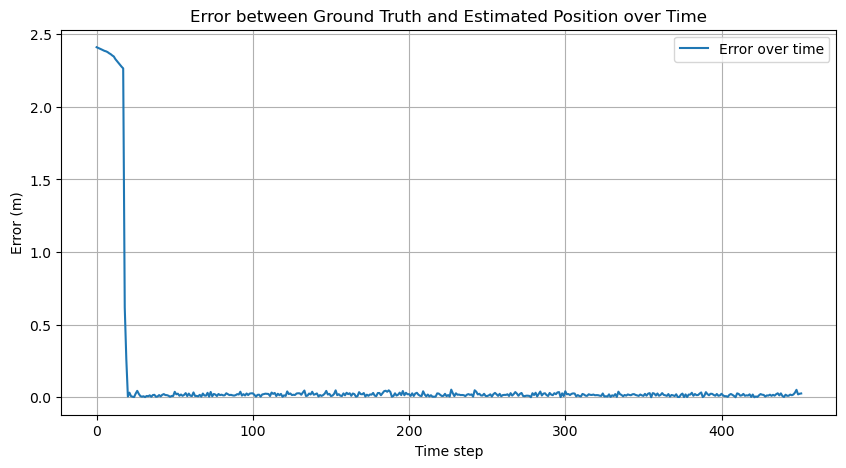

In [6]:
# Calculate error over time
errors = []
for frame in range(len(ground_truth)):
    control_input = [0.5, 0]  # Example control input
    measurement = simulate_landmark_measurements(ground_truth[frame], LANDMARKS, noise_std=0.02)

    # Particle filter steps
    pf.predict(control_input)
    pf.update(measurement, measurement_noise=[0.02], landmarks=LANDMARKS)

    if pf.neff() < NUM_PARTICLES / 2:
        pf.resample()

    # Estimate the state
    estimated_mean, _ = pf.estimate()

    # Calculate error (Euclidean distance)
    error = np.linalg.norm(ground_truth[frame, :2] - estimated_mean[:2])
    errors.append(error)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(errors, label='Error over time')
plt.xlabel('Time step')
plt.ylabel('Error (m)')
plt.title('Error between Ground Truth and Estimated Position over Time')
plt.legend()
plt.grid()
plt.show()